In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import datasets
from custom_models import cnns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "opbs9brd"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [2]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

def execute_script(script):
    model_script = run.file(f"{script}_script.txt")
    model_script = model_script.download(root=root_path / run.name, replace=True)
    model_script.seek(0)
    model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
    model_script.seek(0)
    return model_name, open(model_script.name, "r")

model_name, model_file = execute_script("model")
exec(model_file.read())
datamodule_name, datamodule_file = execute_script("datamodule")
exec(datamodule_file.read())
encoder_name, encoder_file = execute_script("encoder")
exec(encoder_file.read())
decoder_name, decoder_file = execute_script("decoder")
exec(decoder_file.read())

checkpoint = run.file("last.ckpt")
checkpoint.download(root=root_path / run.name, replace=True)

<_io.TextIOWrapper name='tmp/avid-feather-745/last.ckpt' mode='r' encoding='UTF-8'>

In [6]:
dm = eval(datamodule_name)(config=config, repo_path=repo_path)
model = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer = pl.Trainer(devices="auto", accelerator="auto")
raw_predictions = trainer.predict(model, datamodule=dm)
predictions = torch.cat([i[0] for i in raw_predictions])
latent_representation = predict = torch.cat([i[2] for i in raw_predictions])
targets = torch.cat([img for img, _ in dm.val_dataloader()])
descriptors = torch.cat([desc for _, desc in dm.val_dataloader()])


/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [7]:
predictions.shape, targets.shape, descriptors.shape, latent_representation.shape

(torch.Size([180, 3, 64, 64]),
 torch.Size([180, 3, 64, 64]),
 torch.Size([180, 25]),
 torch.Size([180, 50]))

In [21]:
descriptors_df = pd.DataFrame(descriptors, columns=dm.train_df.columns[1:-1])
latent_representation_df = pd.DataFrame(
    latent_representation,
    columns=[f"latent_{i}" for i in range(latent_representation.shape[1])],
)
latent_representation_df


,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,...,latent_40,latent_41,latent_42,latent_43,latent_44,latent_45,latent_46,latent_47,latent_48,latent_49
0,-0.088103,0.041229,0.008595,0.031508,0.047768,0.228283,-0.009297,-0.111448,-0.043623,0.107817,...,0.204573,-0.026320,0.057000,0.023564,-0.039571,0.707246,-0.395450,-0.247977,-0.013185,-0.673916
1,-0.093057,0.116097,0.032476,-0.017328,-0.116915,0.076071,-0.045131,0.180263,-0.170567,0.061256,...,0.156777,-0.081948,-0.246198,-0.327126,0.088098,-0.248363,-0.334996,-0.289700,-0.255963,-0.444647
2,-0.070825,-0.347345,0.400418,-0.001045,-0.082064,0.105829,0.173063,0.020297,0.276712,-0.037901,...,0.100138,-0.509773,-0.002373,0.478537,0.164185,-0.324703,0.528224,0.039578,-0.020382,0.499718
3,0.030961,-0.236834,0.186516,-0.013653,0.216340,0.314817,-0.143286,0.058849,-0.050601,-0.069700,...,-0.105052,-0.144960,0.152409,0.201136,-0.092968,0.122980,0.139950,0.277716,-0.139272,0.228354
4,-0.173110,-0.114540,0.226739,0.192227,0.096212,0.590830,0.082349,0.022943,0.025705,0.057943,...,0.208479,-0.491587,-0.429144,0.087260,-0.213585,-0.521354,-0.380587,-0.032047,-0.117852,-0.695667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.109028,-0.259271,0.268060,-0.069038,0.213966,0.065144,-0.034560,-0.103696,-0.002947,-0.035351,...,-0.140719,-0.178494,0.191158,0.212122,-0.018698,0.386700,0.278860,0.081376,0.049761,0.275742
176,-0.045133,-0.000152,0.138171,0.010912,-0.056040,0.033575,-0.130099,0.176018,-0.260241,0.022103,...,-0.127961,-0.002975,-0.084045,-0.249389,0.008600,-0.417314,-0.183450,-0.149412,-0.243836,-0.021868
177,-0.206524,-0.253539,0.107340,0.003411,0.222287,0.040804,-0.238184,0.008619,0.022876,-0.101341,...,-0.272446,0.328323,0.222988,0.148975,-0.194233,-0.836786,0.262485,0.268114,0.004254,1.028531
178,-0.018918,-0.445590,0.244051,-0.142589,0.285372,0.419130,-0.252347,-0.022861,0.060400,-0.190570,...,-0.563194,-0.119740,0.514074,0.297470,0.009995,-0.617725,0.841397,0.548185,-0.113738,1.632600


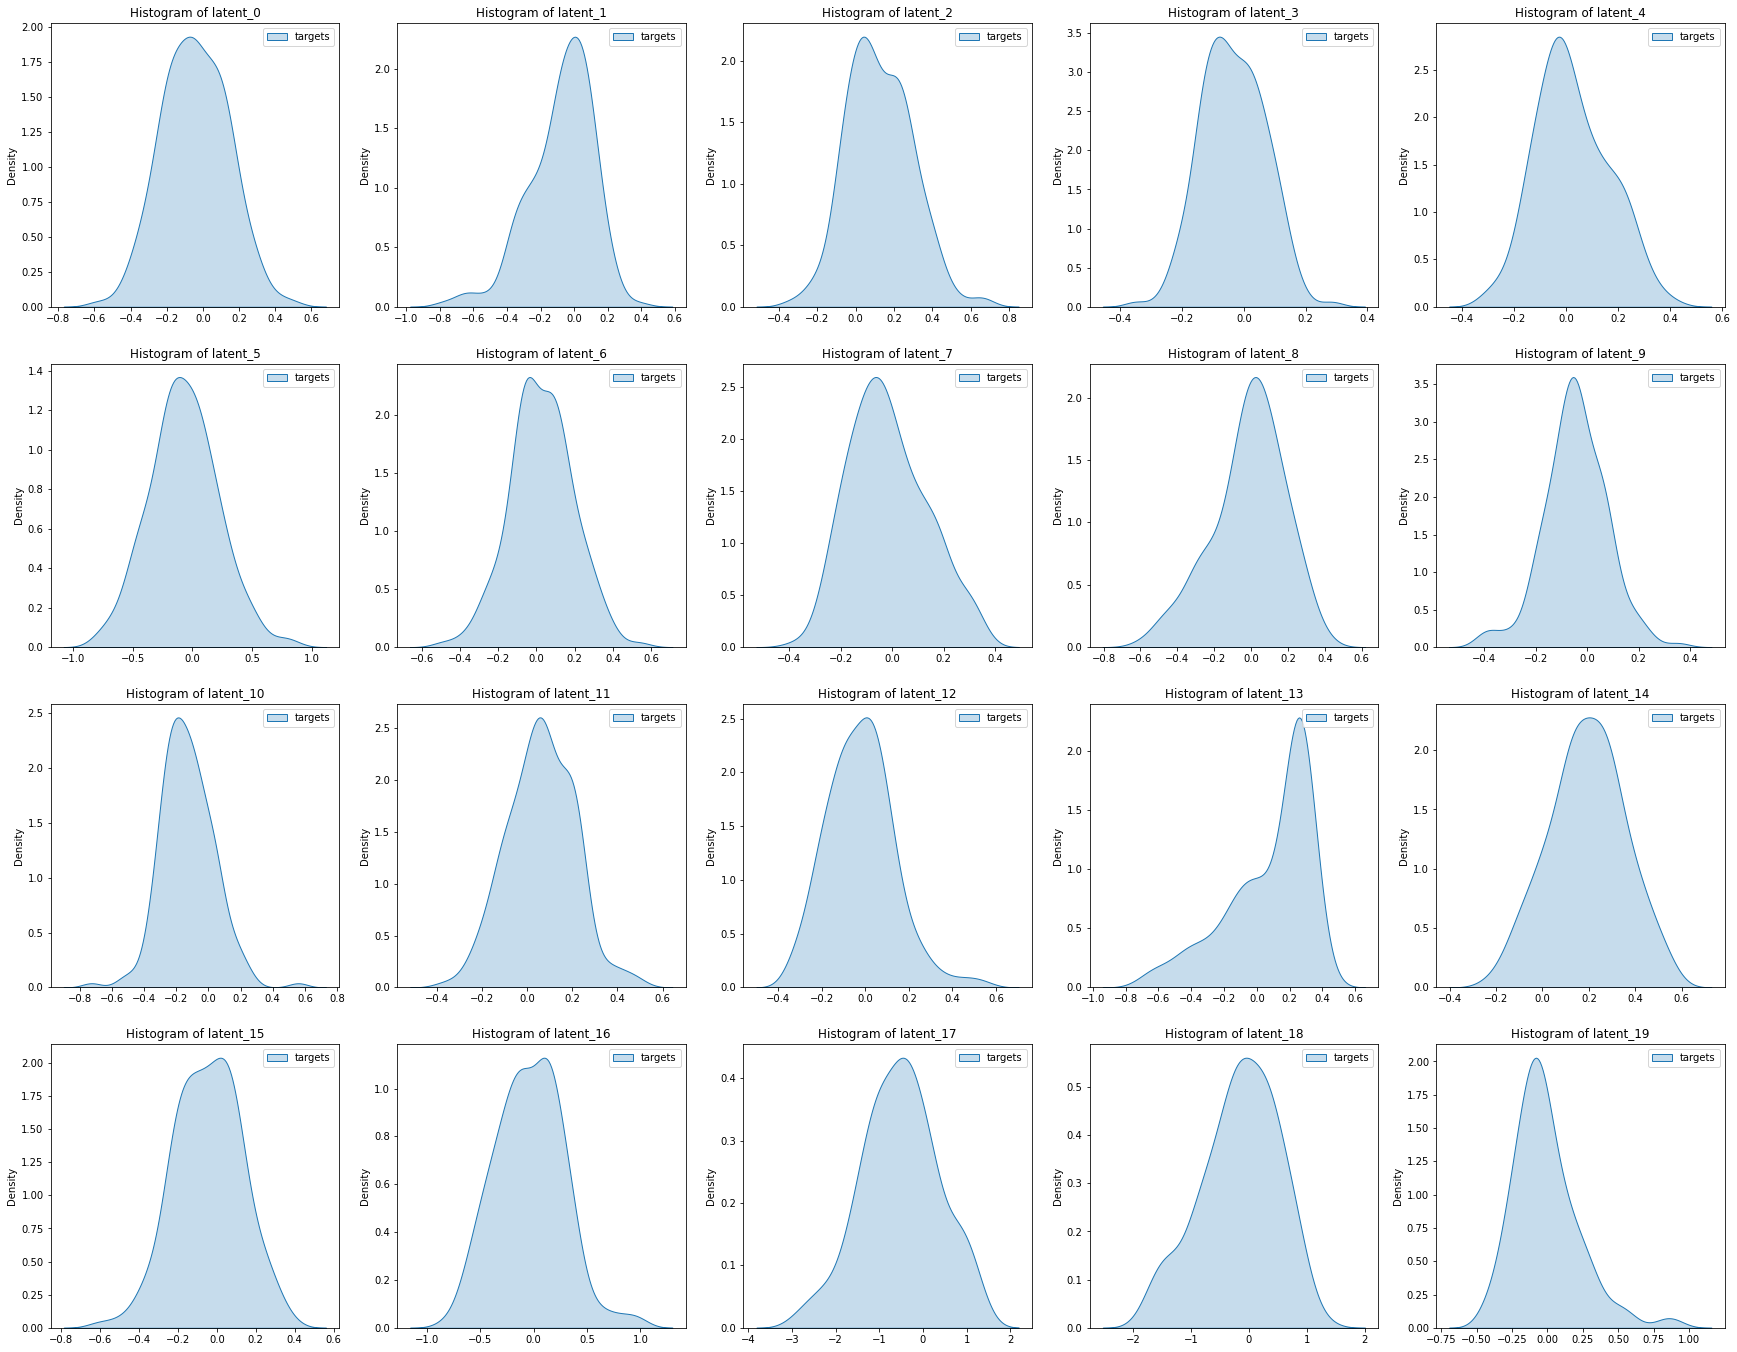

In [26]:
fig, ax = plotting.plot_kde([latent_representation_df.iloc[:, :20]], nb_hist_per_line=5)

In [38]:
df = pd.concat([descriptors_df, latent_representation_df,], axis=1)
df

,nearest_distance_mean,nearest_distance_std,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,orientation-1_std,...,latent_40,latent_41,latent_42,latent_43,latent_44,latent_45,latent_46,latent_47,latent_48,latent_49
0,0.106709,0.122068,0.658552,0.635057,0.326962,0.107960,0.423347,0.541197,0.841397,0.844440,...,0.204573,-0.026320,0.057000,0.023564,-0.039571,0.707246,-0.395450,-0.247977,-0.013185,-0.673916
1,0.626408,0.547785,0.247322,0.235274,0.748895,0.946477,0.503872,0.467956,0.372610,0.322102,...,0.156777,-0.081948,-0.246198,-0.327126,0.088098,-0.248363,-0.334996,-0.289700,-0.255963,-0.444647
2,0.058520,0.074588,0.679301,0.639608,0.313703,0.151053,0.513966,0.315722,0.852996,0.846092,...,0.100138,-0.509773,-0.002373,0.478537,0.164185,-0.324703,0.528224,0.039578,-0.020382,0.499718
3,0.081962,0.069736,0.685357,0.639446,0.310599,0.128148,0.494617,0.612428,0.872771,0.834171,...,-0.105052,-0.144960,0.152409,0.201136,-0.092968,0.122980,0.139950,0.277716,-0.139272,0.228354
4,0.209632,0.058392,0.633222,0.651281,0.331953,0.112318,0.150001,0.704495,0.844848,0.849862,...,0.208479,-0.491587,-0.429144,0.087260,-0.213585,-0.521354,-0.380587,-0.032047,-0.117852,-0.695667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.101540,0.107995,0.636320,0.687226,0.311845,0.124506,0.330238,0.633779,0.834888,0.865538,...,-0.140719,-0.178494,0.191158,0.212122,-0.018698,0.386700,0.278860,0.081376,0.049761,0.275742
176,0.785648,0.657940,0.782691,0.662438,0.247555,0.921348,0.499442,0.628166,0.758583,0.770140,...,-0.127961,-0.002975,-0.084045,-0.249389,0.008600,-0.417314,-0.183450,-0.149412,-0.243836,-0.021868
177,0.076105,0.101486,0.645067,0.644896,0.329001,0.091009,0.336590,0.580131,0.846167,0.880551,...,-0.272446,0.328323,0.222988,0.148975,-0.194233,-0.836786,0.262485,0.268114,0.004254,1.028531
178,0.083779,0.107326,0.634429,0.654139,0.329849,0.066684,0.348688,0.617632,0.855334,0.864309,...,-0.563194,-0.119740,0.514074,0.297470,0.009995,-0.617725,0.841397,0.548185,-0.113738,1.632600


/tmp/ipykernel_1555/2374899545.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


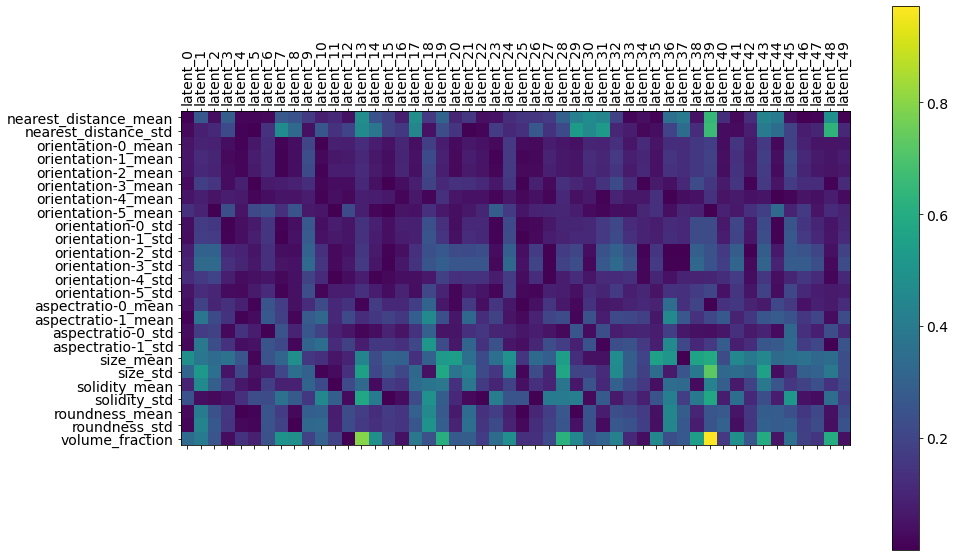

In [47]:
fig, ax = plt.subplots(figsize=(15, 10))
corr = df.corr().iloc[:25, 25:].abs()
img = ax.matshow(corr)
ax.set_xticks(range(corr.select_dtypes(["number"]).shape[1]))
ax.set_xticklabels(
    corr.select_dtypes(["number"]).columns,
    fontsize=14,
    rotation=90,
)
ax.set_yticks(range(corr.select_dtypes(["number"]).shape[0]))
ax.set_yticklabels(
    corr.select_dtypes(["number"]).index,
    fontsize=14,
)
cb = plt.colorbar(img, ax=ax)
cb.ax.tick_params(labelsize=14)
# ax.set_title("Absolute Correlation Matrix", fontsize=16)

fig.show()
